In [1]:
!pip install datasets bert_score pyvi -q
!pip install https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz -q

  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [10414 lines of output]
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        Using cached numpy-2.2.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
        Using cached blis-0.7.11-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.4 kB)
        Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
        Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
        Using cached confection-0.1.5-py3-none-any.whl.metadata (19 kB)
        Using cached annotated_types-0.7

In [30]:
# vi_core_news_lg

In [2]:
!git clone https://github.com/potsawee/selfcheckgpt.git
!mv /content/selfcheckgpt/demo /content/demo
!mv /content/selfcheckgpt/selfcheckgpt /content/selfcheckgpt_
!rm -rf selfcheckgpt
!mv /content/selfcheckgpt_ /content/selfcheckgpt

Cloning into 'selfcheckgpt'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 309 (delta 60), reused 45 (delta 43), pack-reused 239 (from 1)
Receiving objects: 100% (309/309), 1.15 MiB | 923.00 KiB/s, done.
Resolving deltas: 100% (167/167), done.
mv: cannot stat '/content/selfcheckgpt/demo': No such file or directory
mv: cannot stat '/content/selfcheckgpt/selfcheckgpt': No such file or directory
mv: cannot stat '/content/selfcheckgpt_': No such file or directory


In [10]:
import ast
import pandas as pd
import numpy as np
from scipy.stats import entropy
from tqdm.notebook import tqdm
# from datasets import Dataset

In [14]:
from datasets import Dataset

Error importing huggingface_hub.hf_api: No module named 'tqdm.auto'


ModuleNotFoundError: No module named 'tqdm.auto'

# SelfCheckGPT

In [4]:
from SelfCheckBERTScore import SelfCheckBERTScore

ModuleNotFoundError: No module named 'underthesea'

## Load experiment data

In [5]:
def read_csv(path):
    df = pd.read_csv(path)

    for col in df.columns[2:]:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x))
    return Dataset.from_pandas(df)

dataset = read_csv('/content/Vietnamese_hallucination_34_annotated.csv')

In [6]:
label_mapping = {
    'accurate': 0.0,
    'minor_inaccurate': 0.5,
    'major_inaccurate': 1.0,
}

In [7]:
human_label_detect_False   = {}
human_label_detect_False_h = {}
human_label_detect_True    = {}
for idx, i_ in enumerate(range(len(dataset))):
    dataset_i = dataset[i_]
    raw_label = np.array([label_mapping[x] for x in dataset_i['annotation']])
    human_label_detect_False[idx] = (raw_label > 0.499).astype(np.int32).tolist()
    human_label_detect_True[idx]  = (raw_label < 0.499).astype(np.int32).tolist()
    average_score = np.mean(raw_label)
    if average_score < 0.99:
        human_label_detect_False_h[idx] = (raw_label > 0.99).astype(np.int32).tolist()

In [8]:
len(human_label_detect_False), len(human_label_detect_True), len(human_label_detect_False_h)

(20, 20, 20)

# Experimental Setup

In [9]:
def unroll_pred(scores, indices):
    unrolled = []
    for idx in indices:
        unrolled.extend(scores[idx])
    return unrolled

In [10]:
def get_PR_with_human_labels(preds, human_labels, pos_label=1, oneminus_pred=False):
    indices = [k for k in human_labels.keys()]
    unroll_preds = unroll_pred(preds, indices)
    if oneminus_pred:
        unroll_preds = [1.0-x for x in unroll_preds]
    unroll_labels = unroll_pred(human_labels, indices)
    assert len(unroll_preds) == len(unroll_labels)
    print("len:", len(unroll_preds))
    P, R, thre = precision_recall_curve(unroll_labels, unroll_preds, pos_label=pos_label)
    return P, R

In [11]:
def print_AUC(P, R):
    print("AUC: {:.2f}".format(auc(R, P)*100))

In [12]:
# indices = [x['wiki_bio_test_idx'] for x in dataset]

In [ ]:
selfcheck_scores_avg_list = []
selfcheck_scores_max_list = []
n_gram = 5
for n in tqdm(range(1, n_gram + 1)):
    selfcheck_scores_avg = {} # average sentence-level scores
    selfcheck_scores_max = {} # max sentence-level scores
    for i in tqdm(range(len(dataset))):
        x = dataset[i]
        selfcheck_scores_ = SelfCheckBERTScore().predict(
            sentences=x['gemini_sentences'],
            sampled_passages=x['gemini_text_samples']
        )

        selfcheck_scores_avg[i] = selfcheck_scores_['sent_level']['avg_neg_logprob']
        selfcheck_scores_max[i] = selfcheck_scores_['sent_level']['max_neg_logprob']

    selfcheck_scores_avg_list.append(selfcheck_scores_avg)
    selfcheck_scores_max_list.append(selfcheck_scores_max)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized
SelfCheck-1gram initialized


  0%|          | 0/20 [00:00<?, ?it/s]

SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized


/content/selfcheckgpt/modeling_ngram.py:135: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(train_prob)


SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized
SelfCheck-2gram initialized


  0%|          | 0/20 [00:00<?, ?it/s]

SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized
SelfCheck-3gram initialized


  0%|          | 0/20 [00:00<?, ?it/s]

SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized
SelfCheck-4gram initialized


  0%|          | 0/20 [00:00<?, ?it/s]

SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized
SelfCheck-5gram initialized


In [14]:
selfcheck_scores_avg = selfcheck_scores_avg_list[0]
selfcheck_scores_max = selfcheck_scores_max_list[0]

In [15]:
def tmp_fix(selfcheck_scores):
    for i in range(len(selfcheck_scores)):
        for k, v in selfcheck_scores[i].items():
            for j in range(len(v)):
                if v[j] > 10e5:
                    selfcheck_scores[i][k][j] = 10e5

tmp_fix(selfcheck_scores_avg_list)
tmp_fix(selfcheck_scores_max_list)

## Experiment1: Detecting False

In [16]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

In [17]:
# with human label, Detecting False
Prec, Rec = get_PR_with_human_labels(selfcheck_scores_avg, human_label_detect_False, pos_label=1)
print("-----------------------")
print("SelfCheckGPT-NGram on WikiBio")
print_AUC(Prec, Rec)

len: 103
-----------------------
SelfCheckGPT-NGram on WikiBio
AUC: 43.08


In [18]:
arr = []
for v in human_label_detect_False.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.36893203883495146

Text(0.5, 0, 'Recall')

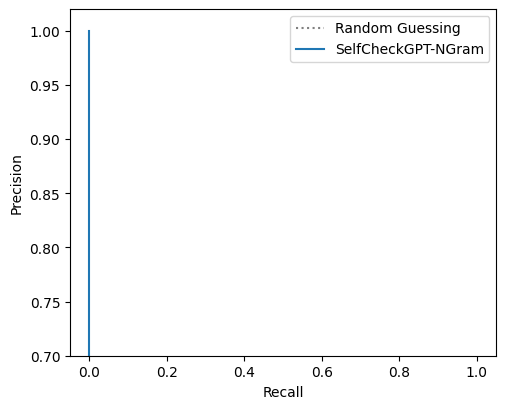

In [19]:
# with human label, Detecting Non-factual
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random Guessing')
plt.plot(Rec, Prec, '-', label='SelfCheckGPT-NGram')
plt.legend()
plt.ylim(0.7,1.02)
plt.ylabel("Precision")
plt.xlabel("Recall")

## Experiment2: Detect False* (harder/less-trivial)

In [20]:
# with human label, Detecting False
Prec, Rec = get_PR_with_human_labels(selfcheck_scores_avg, human_label_detect_False_h, pos_label=1)
print("-----------------------")
print("SelfCheckGPT-NGram on WikiBio")
print_AUC(Prec, Rec)

len: 103
-----------------------
SelfCheckGPT-NGram on WikiBio
AUC: 11.56


In [21]:
arr = []
for v in human_label_detect_False_h.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.0970873786407767

Text(0.5, 0, 'Recall')

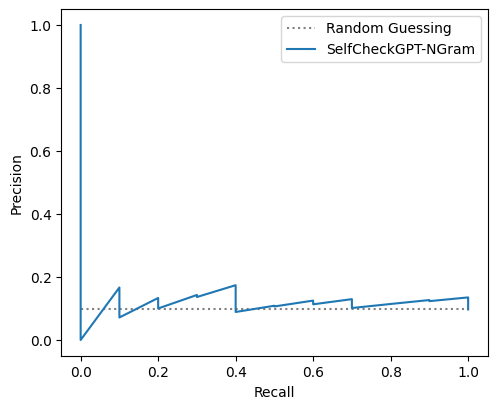

In [22]:
# with human label, Detecting Non-factual*
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random Guessing')
plt.plot(Rec, Prec, '-', label='SelfCheckGPT-NGram')
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")

## Experiment3: Detecting True

In [23]:
# with human label, Detecting True
Prec, Rec = get_PR_with_human_labels(selfcheck_scores_avg, human_label_detect_True, pos_label=1, oneminus_pred=True)
print("-----------------------")
print("SelfCheckGPT-NGram on WikiBio")
print_AUC(Prec, Rec)

len: 103
-----------------------
SelfCheckGPT-NGram on WikiBio
AUC: 67.73


In [24]:
arr = []
for v in human_label_detect_True.values():
    arr.extend(v)
random_baseline = np.mean(arr)
random_baseline

0.6310679611650486

Text(0.5, 0, 'Recall')

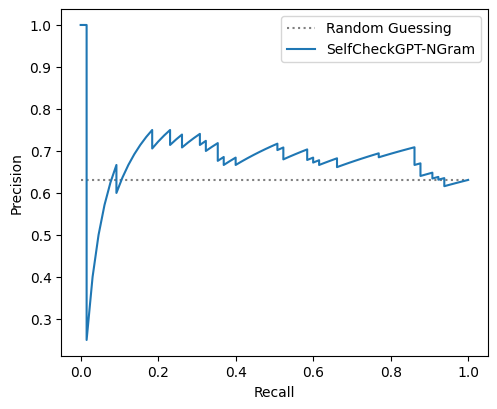

In [25]:
# with human label, Detecting Non-factual*
plt.figure(figsize=(5.5, 4.5))
plt.hlines(y=random_baseline, xmin=0, xmax=1.0, color='grey', linestyles='dotted', label='Random Guessing')
plt.plot(Rec, Prec, '-', label='SelfCheckGPT-NGram')
plt.legend()
plt.ylabel("Precision")
plt.xlabel("Recall")

## Table of results

In [26]:
def generate_table_results(selfcheck_scores):
    df = pd.DataFrame(columns=['n-gram', 'NoFac', 'NoFac*', 'Fac'])
    for idx, n in enumerate(range(1, n_gram + 1)):
        selfcheck_scores_ = selfcheck_scores[idx]
        try:
            df.loc[idx, 'n-gram'] = n

            Prec, Rec = get_PR_with_human_labels(selfcheck_scores_, human_label_detect_False, pos_label=1)
            df.loc[idx, 'NoFac'] = auc(Rec, Prec)*100

            print(df.loc[idx, 'NoFac'])

            Prec, Rec = get_PR_with_human_labels(selfcheck_scores_, human_label_detect_False_h, pos_label=1)
            df.loc[idx, 'NoFac*'] = auc(Rec, Prec)*100

            print(df.loc[idx, 'NoFac*'])

            Prec, Rec = get_PR_with_human_labels(selfcheck_scores_, human_label_detect_True, pos_label=1, oneminus_pred=True)
            df.loc[idx, 'Fac'] = auc(Rec, Prec)*100

        except Exception as e:
            print(e)
            continue

    return df

In [27]:
generate_table_results(selfcheck_scores_avg_list)

len: 103
43.07545589512571
len: 103
11.557855821976498
len: 103
len: 103
39.12205760012453
len: 103
10.045932448568825
len: 103
len: 103
40.85399317841838
len: 103
8.7849709541221
len: 103
len: 103
39.9327988314376
len: 103
8.383860936473113
len: 103
len: 103
37.74015650714307
len: 103
8.000005052527245
len: 103


,n-gram,NoFac,NoFac*,Fac
0,1,43.075456,11.557856,67.727552
1,2,39.122058,10.045932,64.344498
2,3,40.853993,8.784971,64.918578
3,4,39.932799,8.383861,64.266125
4,5,37.740157,8.000005,63.150882


In [28]:
generate_table_results(selfcheck_scores_max_list)

len: 103
38.295491313071665
len: 103
8.506962943881893
len: 103
len: 103
37.39528678502423
len: 103
13.161190427393588
len: 103
len: 103
44.15141415884874
len: 103
16.831678421958063
len: 103
len: 103
41.56988819729609
len: 103
16.108542605207063
len: 103
len: 103
40.60854307436195
len: 103
14.063942878067365
len: 103


,n-gram,NoFac,NoFac*,Fac
0,1,38.295491,8.506963,68.189996
1,2,37.395287,13.16119,63.839341
2,3,44.151414,16.831678,64.54349
3,4,41.569888,16.108543,63.651547
4,5,40.608543,14.063943,63.663775
